# FINAL MODEL - RESTNET-18 (CNN) - 244x244

In [1]:
# --- Cell 0: WSL path helper + diagnostics ---
import os, platform, glob
from pathlib import PureWindowsPath

def is_wsl():
    try:
        return ("microsoft" in platform.release().lower()) or ("wsl" in platform.version().lower())
    except Exception:
        return False

def win_to_wsl_path(win_path: str) -> str:
    if not is_wsl(): return win_path
    if ":" not in win_path: return win_path
    p = PureWindowsPath(win_path)
    drive = str(p.drive).replace(":", "").lower()
    tail = str(p).replace("\\", "/").split(":/")[-1]
    return f"/mnt/{drive}/{tail}"

def peek_some_images(root, classes=("CNV","DME","DRUSEN","NORMAL"), max_show=3):
    print(f"\nPeeking into: {root}")
    for split in ("train","val","test"):
        split_dir = os.path.join(root, split)
        print(f"\n[{split}] exists: {os.path.isdir(split_dir)} -> {split_dir}")
        for cls in classes:
            cls_dir = os.path.join(split_dir, cls)
            imgs = []
            if os.path.isdir(cls_dir):
                for pat in ("*.png","*.jpg","*.jpeg","*.tif","*.bmp"):
                    imgs.extend(glob.glob(os.path.join(cls_dir, pat)))
            print(f"  {cls:<7} -> {len(imgs):6d} files | path: {cls_dir}")
            for s in imgs[:max_show]:
                print("    -", os.path.basename(s))

# --- Your Windows dataset path & save folder (edit if needed) ---
WIN_DATA_ROOT = r"C:\Users\sheno\OneDrive\CODCSD201F-006-SetupFile\Desktop\FINAL\dataset\OCT2017_70_15_15"
WIN_MODELS_DIR = r"C:\Users\sheno\OneDrive\CODCSD201F-006-SetupFile\Desktop\FINAL\models"

DATA_ROOT   = win_to_wsl_path(WIN_DATA_ROOT)
MODELS_DIR  = win_to_wsl_path(WIN_MODELS_DIR)

print("Running in WSL:", is_wsl())
print("DATA_ROOT  ->", DATA_ROOT)
print("MODELS_DIR ->", MODELS_DIR)
peek_some_images(DATA_ROOT)


Running in WSL: True
DATA_ROOT  -> /mnt/c/Users/sheno/OneDrive/CODCSD201F-006-SetupFile/Desktop/FINAL/dataset/OCT2017_70_15_15
MODELS_DIR -> /mnt/c/Users/sheno/OneDrive/CODCSD201F-006-SetupFile/Desktop/FINAL/models

Peeking into: /mnt/c/Users/sheno/OneDrive/CODCSD201F-006-SetupFile/Desktop/FINAL/dataset/OCT2017_70_15_15

[train] exists: True -> /mnt/c/Users/sheno/OneDrive/CODCSD201F-006-SetupFile/Desktop/FINAL/dataset/OCT2017_70_15_15/train
  CNV     ->  26216 files | path: /mnt/c/Users/sheno/OneDrive/CODCSD201F-006-SetupFile/Desktop/FINAL/dataset/OCT2017_70_15_15/train/CNV
    - CNV-1016042-1.png
    - CNV-1016042-10.png
    - CNV-1016042-100.png
  DME     ->   8116 files | path: /mnt/c/Users/sheno/OneDrive/CODCSD201F-006-SetupFile/Desktop/FINAL/dataset/OCT2017_70_15_15/train/DME
    - DME-1072015-1.png
    - DME-1072015-2.png
    - DME-1072015-3.png
  DRUSEN  ->   6201 files | path: /mnt/c/Users/sheno/OneDrive/CODCSD201F-006-SetupFile/Desktop/FINAL/dataset/OCT2017_70_15_15/train/DRUS

In [2]:
# --- Cell 1: Imports & utilities ---
import os, time, copy, random, gc
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler, Subset
from torchvision import transforms, datasets, models
from torch.cuda.amp import autocast, GradScaler

from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm

# Reproducibility
SEED = 42
random.seed(SEED); np.random.seed(SEED)
torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True  # set False + deterministic=True for exact reproducibility

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available(): print("GPU:", torch.cuda.get_device_name(0))

def clean_mem():
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()


Torch: 2.8.0+cu128
CUDA available: True
GPU: NVIDIA GeForce GTX 1650 Ti


In [3]:
# --- Cell 2: Config & structure check ---

TRAIN_DIR = os.path.join(DATA_ROOT, "train")
VAL_DIR   = os.path.join(DATA_ROOT, "val")
TEST_DIR  = os.path.join(DATA_ROOT, "test")

EXPECTED_CLASSES = ["CNV", "DME", "DRUSEN", "NORMAL"]

# Training config
IMG_SIZE      = 224       # (we don't resize again; kept for ref)
BATCH_SIZE    = 32
NUM_WORKERS   = 4
EPOCHS        = 20
LR            = 3e-4
WEIGHT_DECAY  = 1e-4
LABEL_SMOOTH  = 0.05
MODEL_NAME    = "resnet18"   # "resnet18" | "resnet50" | "convnext_tiny"
PATIENCE      = 5

# K-Fold CV
N_FOLDS       = 5            # CV on (train + val); test is held out
RANDOM_STATE  = 123

os.makedirs("checkpoints", exist_ok=True)
os.makedirs("runs", exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)

def check_structure(root, splits=("train","val","test"), classes=EXPECTED_CLASSES):
    problems = []
    for split in splits:
        split_path = os.path.join(root, split)
        if not os.path.isdir(split_path): problems.append(f"Missing split folder: {split_path}"); continue
        for cls in classes:
            cls_path = os.path.join(split_path, cls)
            if not os.path.isdir(cls_path): problems.append(f"Missing class folder: {cls_path}")
            else:
                files = [f for f in os.listdir(cls_path) if os.path.isfile(os.path.join(cls_path,f))]
                if not files: problems.append(f"No files in: {cls_path} (hydrate OneDrive?)")
    if problems:
        print("❌ Structure issues:")
        for p in problems: print(" -", p)
        raise FileNotFoundError("Fix dataset structure before continuing.")
    print("✅ Dataset structure looks good.")

check_structure(DATA_ROOT)


✅ Dataset structure looks good.


In [4]:
# --- Cell 3: Discover data & counts ---
tmp_train = datasets.ImageFolder(TRAIN_DIR)
tmp_val   = datasets.ImageFolder(VAL_DIR)
tmp_test  = datasets.ImageFolder(TEST_DIR)

class_names = tmp_train.classes
print("Classes:", class_names)
assert sorted(class_names) == sorted(EXPECTED_CLASSES), "Classes on disk don't match EXPECTED_CLASSES."

def count_per_class(ds):
    cnt = Counter([y for _, y in ds.samples])
    return {class_names[i]: cnt[i] for i in range(len(class_names))}

print("Train counts:", count_per_class(tmp_train))
print("Val counts  :", count_per_class(tmp_val))
print("Test counts :", count_per_class(tmp_test))

# Build a combined TRAIN+VAL list for K-fold CV
trainval_samples = tmp_train.samples + tmp_val.samples  # list of (path, label_idx)
trainval_paths  = [p for p, _ in trainval_samples]
trainval_labels = np.array([y for _, y in trainval_samples])
print(f"Total train+val images for CV: {len(trainval_samples)}")


Classes: ['CNV', 'DME', 'DRUSEN', 'NORMAL']
Train counts: {'CNV': 26216, 'DME': 8116, 'DRUSEN': 6201, 'NORMAL': 18593}
Val counts  : {'CNV': 5618, 'DME': 1739, 'DRUSEN': 1329, 'NORMAL': 3984}
Test counts : {'CNV': 5617, 'DME': 1739, 'DRUSEN': 1329, 'NORMAL': 3984}
Total train+val images for CV: 71796


In [5]:
# --- Cell 4: Transforms ---
base_train_t = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

def heavy_aug_t():
    return transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.RandomApply([transforms.RandomRotation(degrees=10)], p=0.6),
        transforms.RandomApply([transforms.RandomAffine(degrees=0, translate=(0.05,0.05), scale=(0.95,1.05))], p=0.6),
        transforms.RandomHorizontalFlip(p=0.6),
        transforms.RandomVerticalFlip(p=0.15),
        transforms.RandomApply([transforms.ColorJitter(brightness=0.10, contrast=0.10)], p=0.3),
        transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
    ])

base_eval_t = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])


In [6]:
# --- Cell 5: Datasets & loaders ---
from PIL import Image

class ClassAwareImageFolder(Dataset):
    """Folder-backed dataset (used for TEST only)."""
    def __init__(self, root, default_transform, class_transforms=None):
        self.inner = datasets.ImageFolder(root=root)
        self.default_transform = default_transform
        self.class_transforms = class_transforms or {}
        self.name_to_idx = self.inner.class_to_idx
        self.idx_to_transform = {self.name_to_idx[n]: t for n, t in self.class_transforms.items() if n in self.name_to_idx}

    def __len__(self): return len(self.inner)
    def __getitem__(self, i):
        path, label = self.inner.samples[i]
        img = self.inner.loader(path)
        t = self.idx_to_transform.get(label, self.default_transform)
        img = t(img)
        return img, label

    @property
    def samples(self): return self.inner.samples

class ClassAwareListDataset(Dataset):
    """List-backed dataset for CV: takes (path,label) list so we can split by indices."""
    def __init__(self, samples, default_transform, class_transforms=None):
        self.samples = samples  # list of (path, label_idx)
        self.default_transform = default_transform
        self.class_transforms = class_transforms or {}
        self.idx_to_transform = self.class_transforms  # already keyed by label_idx

    def __len__(self): return len(self.samples)
    def __getitem__(self, i):
        path, label = self.samples[i]
        img = Image.open(path).convert("RGB")  # PIL loader
        t = self.idx_to_transform.get(label, self.default_transform)
        img = t(img)
        return img, label

def build_loaders_from_indices(train_idx, val_idx):
    # minority classes in the current TRAIN split
    train_labels = [trainval_labels[i] for i in train_idx]
    cnt = Counter(train_labels)
    counts_list = [cnt[i] for i in range(len(class_names))]
    median_count = sorted(counts_list)[len(counts_list)//2]
    minority_idx = [i for i, c in enumerate(counts_list) if c <= median_count]
    minority_names = [class_names[i] for i in minority_idx]
    class_transforms = {i: heavy_aug_t() for i in minority_idx}

    train_samples = [trainval_samples[i] for i in train_idx]
    val_samples   = [trainval_samples[i] for i in val_idx]

    train_ds = ClassAwareListDataset(train_samples, default_transform=base_train_t, class_transforms=class_transforms)
    val_ds   = ClassAwareListDataset(val_samples,   default_transform=base_eval_t)

    # Weighted sampler for TRAIN
    class_count_map = Counter([y for _, y in train_samples])
    sample_weights = [1.0 / class_count_map[y] for _, y in train_samples]
    sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

    def worker_init_fn(worker_id): np.random.seed(SEED + worker_id)

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler,
                              num_workers=NUM_WORKERS, pin_memory=True, worker_init_fn=worker_init_fn)
    val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False,
                              num_workers=NUM_WORKERS, pin_memory=True)
    return train_ds, val_ds, train_loader, val_loader

# Test dataset (held-out)
test_ds     = ClassAwareImageFolder(TEST_DIR, default_transform=base_eval_t)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False,
                         num_workers=NUM_WORKERS, pin_memory=True)


In [7]:
# --- Cell 6: Model builder ---
def build_model(num_classes, name="resnet18"):
    if name == "resnet18":
        m = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        m.fc = nn.Linear(m.fc.in_features, num_classes)
    elif name == "resnet50":
        m = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
        m.fc = nn.Linear(m.fc.in_features, num_classes)
    elif name == "convnext_tiny":
        m = models.convnext_tiny(weights=models.ConvNeXt_Tiny_Weights.IMAGENET1K_V1)
        m.classifier[-1] = nn.Linear(m.classifier[-1].in_features, num_classes)
    else:
        raise ValueError("Unsupported MODEL_NAME:", name)
    return m


In [8]:
# --- Cell 7: Train/Eval helpers + plots + savers ---
@torch.no_grad()
def evaluate(loader, model):
    model.eval()
    all_y, all_p = [], []
    for x, y in loader:
        x, y = x.to(DEVICE, non_blocking=True), y.to(DEVICE, non_blocking=True)
        logits = model(x)
        preds = logits.argmax(1)
        all_y.append(y.cpu().numpy()); all_p.append(preds.cpu().numpy())
    y_true = np.concatenate(all_y); y_pred = np.concatenate(all_p)
    acc = accuracy_score(y_true, y_pred)
    macro_f1 = f1_score(y_true, y_pred, average="macro")
    cm = confusion_matrix(y_true, y_pred, labels=list(range(len(class_names))))
    return acc, macro_f1, cm, y_true, y_pred

def train_one_epoch(model, loader, optimizer, scaler, criterion):
    model.train()
    running_loss, seen = 0.0, 0
    for x, y in tqdm(loader, leave=False):
        x, y = x.to(DEVICE, non_blocking=True), y.to(DEVICE, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)
        with autocast():
            logits = model(x)
            loss = criterion(logits, y)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item() * x.size(0)
        seen += x.size(0)
    return running_loss / max(1, seen)

def plot_history(history, save_prefix=None):
    epochs = range(1, len(history["train_loss"]) + 1)
    plt.figure(figsize=(12,5))
    # loss
    plt.subplot(1,2,1)
    plt.plot(epochs, history["train_loss"], 'b-o', label="Train Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Training Loss Curve"); plt.legend()
    # val
    plt.subplot(1,2,2)
    plt.plot(epochs, history["val_acc"], 'g-o', label="Val Accuracy")
    plt.plot(epochs, history["val_f1"],  'r-o', label="Val F1")
    plt.xlabel("Epoch"); plt.ylabel("Score"); plt.title("Validation Accuracy & F1"); plt.legend()
    plt.tight_layout()
    if save_prefix:
        plt.savefig(f"{save_prefix}_curves.png", dpi=200, bbox_inches="tight")
    plt.show()

def save_checkpoint(model_state, classes, epoch, val_acc, val_f1, prefix):
    ckpt = {
        "model_state": model_state,
        "classes": classes,
        "epoch": epoch,
        "val_acc": float(val_acc),
        "val_f1": float(val_f1),
        "config": {"MODEL_NAME": MODEL_NAME, "IMG_SIZE": IMG_SIZE, "BATCH_SIZE": BATCH_SIZE, "LR": LR, "WEIGHT_DECAY": WEIGHT_DECAY}
    }
    path = f"checkpoints/{prefix}.pth"
    torch.save(ckpt, path)
    # also mirror to your Windows folder
    torch.save(ckpt, os.path.join(MODELS_DIR, f"{prefix}.pth"))
    return path



========== Fold 1/5 ==========


/tmp/ipykernel_298904/192118246.py:18: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
  0%|          | 0/1795 [00:00<?, ?it/s]/tmp/ipykernel_298904/2572183642.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Fold 1 | Epoch 01 | loss 0.4065 | val_acc 0.9260 | val_f1 0.8759 | lr 2.98e-04 | 1113.4s
  ↳ Saved best fold checkpoint to: checkpoints/resnet18_fold1_best.pth


  0%|          | 0/1795 [00:00<?, ?it/s]/tmp/ipykernel_298904/2572183642.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Fold 1 | Epoch 02 | loss 0.3379 | val_acc 0.9491 | val_f1 0.9285 | lr 2.93e-04 | 1069.8s
  ↳ Saved best fold checkpoint to: checkpoints/resnet18_fold1_best.pth


  0%|          | 0/1795 [00:00<?, ?it/s]/tmp/ipykernel_298904/2572183642.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Fold 1 | Epoch 03 | loss 0.3256 | val_acc 0.9171 | val_f1 0.8906 | lr 2.84e-04 | 1069.4s


  0%|          | 0/1795 [00:00<?, ?it/s]/tmp/ipykernel_298904/2572183642.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Fold 1 | Epoch 04 | loss 0.3080 | val_acc 0.9583 | val_f1 0.9412 | lr 2.71e-04 | 1073.1s
  ↳ Saved best fold checkpoint to: checkpoints/resnet18_fold1_best.pth


  0%|          | 0/1795 [00:00<?, ?it/s]/tmp/ipykernel_298904/2572183642.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Fold 1 | Epoch 05 | loss 0.3017 | val_acc 0.9453 | val_f1 0.9275 | lr 2.56e-04 | 1068.1s


  0%|          | 0/1795 [00:00<?, ?it/s]/tmp/ipykernel_298904/2572183642.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Fold 1 | Epoch 06 | loss 0.2946 | val_acc 0.9605 | val_f1 0.9429 | lr 2.38e-04 | 1068.1s
  ↳ Saved best fold checkpoint to: checkpoints/resnet18_fold1_best.pth


  0%|          | 0/1795 [00:00<?, ?it/s]/tmp/ipykernel_298904/2572183642.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Fold 1 | Epoch 07 | loss 0.2845 | val_acc 0.9558 | val_f1 0.9329 | lr 2.18e-04 | 1069.4s


  0%|          | 0/1795 [00:00<?, ?it/s]/tmp/ipykernel_298904/2572183642.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Fold 1 | Epoch 08 | loss 0.2802 | val_acc 0.9616 | val_f1 0.9457 | lr 1.96e-04 | 1070.7s
  ↳ Saved best fold checkpoint to: checkpoints/resnet18_fold1_best.pth


  0%|          | 0/1795 [00:00<?, ?it/s]/tmp/ipykernel_298904/2572183642.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Fold 1 | Epoch 09 | loss 0.2750 | val_acc 0.9608 | val_f1 0.9428 | lr 1.73e-04 | 1068.7s


  0%|          | 0/1795 [00:00<?, ?it/s]/tmp/ipykernel_298904/2572183642.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Fold 1 | Epoch 10 | loss 0.2693 | val_acc 0.9671 | val_f1 0.9525 | lr 1.50e-04 | 1069.2s
  ↳ Saved best fold checkpoint to: checkpoints/resnet18_fold1_best.pth


  0%|          | 0/1795 [00:00<?, ?it/s]/tmp/ipykernel_298904/2572183642.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Fold 1 | Epoch 11 | loss 0.2610 | val_acc 0.9640 | val_f1 0.9463 | lr 1.27e-04 | 1069.6s


  0%|          | 0/1795 [00:00<?, ?it/s]/tmp/ipykernel_298904/2572183642.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Fold 1 | Epoch 12 | loss 0.2567 | val_acc 0.9682 | val_f1 0.9546 | lr 1.04e-04 | 1086.7s
  ↳ Saved best fold checkpoint to: checkpoints/resnet18_fold1_best.pth


  0%|          | 0/1795 [00:00<?, ?it/s]/tmp/ipykernel_298904/2572183642.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Fold 1 | Epoch 13 | loss 0.2534 | val_acc 0.9680 | val_f1 0.9536 | lr 8.19e-05 | 1073.9s


  0%|          | 0/1795 [00:00<?, ?it/s]/tmp/ipykernel_298904/2572183642.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Fold 1 | Epoch 14 | loss 0.2466 | val_acc 0.9704 | val_f1 0.9575 | lr 6.18e-05 | 1076.0s
  ↳ Saved best fold checkpoint to: checkpoints/resnet18_fold1_best.pth


  0%|          | 0/1795 [00:00<?, ?it/s]/tmp/ipykernel_298904/2572183642.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Fold 1 | Epoch 15 | loss 0.2427 | val_acc 0.9714 | val_f1 0.9587 | lr 4.39e-05 | 1074.9s
  ↳ Saved best fold checkpoint to: checkpoints/resnet18_fold1_best.pth


  0%|          | 0/1795 [00:00<?, ?it/s]/tmp/ipykernel_298904/2572183642.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Fold 1 | Epoch 16 | loss 0.2388 | val_acc 0.9719 | val_f1 0.9591 | lr 2.86e-05 | 1075.0s
  ↳ Saved best fold checkpoint to: checkpoints/resnet18_fold1_best.pth


  0%|          | 0/1795 [00:00<?, ?it/s]/tmp/ipykernel_298904/2572183642.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Fold 1 | Epoch 17 | loss 0.2361 | val_acc 0.9724 | val_f1 0.9598 | lr 1.63e-05 | 1075.2s
  ↳ Saved best fold checkpoint to: checkpoints/resnet18_fold1_best.pth


  0%|          | 0/1795 [00:00<?, ?it/s]/tmp/ipykernel_298904/2572183642.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Fold 1 | Epoch 18 | loss 0.2347 | val_acc 0.9724 | val_f1 0.9597 | lr 7.34e-06 | 1079.2s


  0%|          | 0/1795 [00:00<?, ?it/s]/tmp/ipykernel_298904/2572183642.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Fold 1 | Epoch 19 | loss 0.2325 | val_acc 0.9737 | val_f1 0.9621 | lr 1.85e-06 | 1066.4s
  ↳ Saved best fold checkpoint to: checkpoints/resnet18_fold1_best.pth


  0%|          | 0/1795 [00:00<?, ?it/s]/tmp/ipykernel_298904/2572183642.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Fold 1 | Epoch 20 | loss 0.2323 | val_acc 0.9730 | val_f1 0.9606 | lr 0.00e+00 | 1061.8s


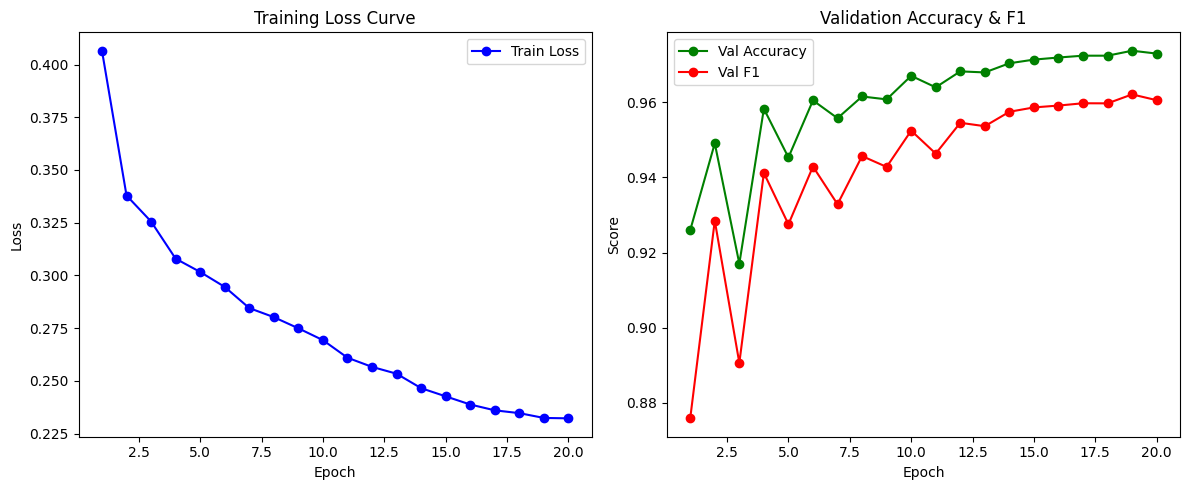


========== Fold 2/5 ==========


/tmp/ipykernel_298904/192118246.py:18: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
  0%|          | 0/1795 [00:00<?, ?it/s]/tmp/ipykernel_298904/2572183642.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Fold 2 | Epoch 01 | loss 0.4073 | val_acc 0.9363 | val_f1 0.9132 | lr 2.98e-04 | 1088.2s
  ↳ Saved best fold checkpoint to: checkpoints/resnet18_fold2_best.pth


  0%|          | 0/1795 [00:00<?, ?it/s]/tmp/ipykernel_298904/2572183642.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Fold 2 | Epoch 02 | loss 0.3418 | val_acc 0.9340 | val_f1 0.8900 | lr 2.93e-04 | 1067.8s


  0%|          | 0/1795 [00:00<?, ?it/s]/tmp/ipykernel_298904/2572183642.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Fold 2 | Epoch 03 | loss 0.3229 | val_acc 0.9496 | val_f1 0.9304 | lr 2.84e-04 | 1067.4s
  ↳ Saved best fold checkpoint to: checkpoints/resnet18_fold2_best.pth


  0%|          | 0/1795 [00:00<?, ?it/s]/tmp/ipykernel_298904/2572183642.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Fold 2 | Epoch 04 | loss 0.3089 | val_acc 0.9578 | val_f1 0.9402 | lr 2.71e-04 | 1083.6s
  ↳ Saved best fold checkpoint to: checkpoints/resnet18_fold2_best.pth


  0%|          | 0/1795 [00:00<?, ?it/s]/tmp/ipykernel_298904/2572183642.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Fold 2 | Epoch 05 | loss 0.3027 | val_acc 0.9480 | val_f1 0.9224 | lr 2.56e-04 | 1082.3s


  0%|          | 0/1795 [00:00<?, ?it/s]/tmp/ipykernel_298904/2572183642.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Fold 2 | Epoch 06 | loss 0.2936 | val_acc 0.9600 | val_f1 0.9420 | lr 2.38e-04 | 1086.6s
  ↳ Saved best fold checkpoint to: checkpoints/resnet18_fold2_best.pth


  0%|          | 0/1795 [00:00<?, ?it/s]/tmp/ipykernel_298904/2572183642.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Fold 2 | Epoch 07 | loss 0.2845 | val_acc 0.9487 | val_f1 0.9228 | lr 2.18e-04 | 1083.4s


  0%|          | 0/1795 [00:00<?, ?it/s]/tmp/ipykernel_298904/2572183642.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Fold 2 | Epoch 08 | loss 0.2806 | val_acc 0.9616 | val_f1 0.9453 | lr 1.96e-04 | 1071.5s
  ↳ Saved best fold checkpoint to: checkpoints/resnet18_fold2_best.pth


  0%|          | 0/1795 [00:00<?, ?it/s]/tmp/ipykernel_298904/2572183642.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Fold 2 | Epoch 09 | loss 0.2734 | val_acc 0.9586 | val_f1 0.9384 | lr 1.73e-04 | 1076.5s


  0%|          | 0/1795 [00:00<?, ?it/s]/tmp/ipykernel_298904/2572183642.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Fold 2 | Epoch 10 | loss 0.2637 | val_acc 0.9613 | val_f1 0.9433 | lr 1.50e-04 | 1082.5s


  0%|          | 0/1795 [00:00<?, ?it/s]/tmp/ipykernel_298904/2572183642.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Fold 2 | Epoch 11 | loss 0.2594 | val_acc 0.9642 | val_f1 0.9486 | lr 1.27e-04 | 1083.0s
  ↳ Saved best fold checkpoint to: checkpoints/resnet18_fold2_best.pth


  0%|          | 0/1795 [00:00<?, ?it/s]/tmp/ipykernel_298904/2572183642.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Fold 2 | Epoch 12 | loss 0.2542 | val_acc 0.9636 | val_f1 0.9464 | lr 1.04e-04 | 1072.3s


  0%|          | 0/1795 [00:00<?, ?it/s]/tmp/ipykernel_298904/2572183642.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Fold 2 | Epoch 13 | loss 0.2502 | val_acc 0.9646 | val_f1 0.9479 | lr 8.19e-05 | 1076.4s


  0%|          | 0/1795 [00:00<?, ?it/s]/tmp/ipykernel_298904/2572183642.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Fold 2 | Epoch 14 | loss 0.2445 | val_acc 0.9706 | val_f1 0.9577 | lr 6.18e-05 | 1081.9s
  ↳ Saved best fold checkpoint to: checkpoints/resnet18_fold2_best.pth


  0%|          | 0/1795 [00:00<?, ?it/s]/tmp/ipykernel_298904/2572183642.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Fold 2 | Epoch 15 | loss 0.2406 | val_acc 0.9716 | val_f1 0.9590 | lr 4.39e-05 | 1082.2s
  ↳ Saved best fold checkpoint to: checkpoints/resnet18_fold2_best.pth


  0%|          | 0/1795 [00:00<?, ?it/s]/tmp/ipykernel_298904/2572183642.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Fold 2 | Epoch 16 | loss 0.2383 | val_acc 0.9685 | val_f1 0.9535 | lr 2.86e-05 | 1082.3s


  0%|          | 0/1795 [00:00<?, ?it/s]/tmp/ipykernel_298904/2572183642.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Fold 2 | Epoch 17 | loss 0.2360 | val_acc 0.9697 | val_f1 0.9562 | lr 1.63e-05 | 1083.3s


  0%|          | 0/1795 [00:00<?, ?it/s]/tmp/ipykernel_298904/2572183642.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Fold 2 | Epoch 18 | loss 0.2332 | val_acc 0.9710 | val_f1 0.9582 | lr 7.34e-06 | 1077.2s


  0%|          | 0/1795 [00:00<?, ?it/s]/tmp/ipykernel_298904/2572183642.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Fold 2 | Epoch 19 | loss 0.2316 | val_acc 0.9705 | val_f1 0.9574 | lr 1.85e-06 | 1073.7s


  0%|          | 0/1795 [00:00<?, ?it/s]/tmp/ipykernel_298904/2572183642.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Fold 2 | Epoch 20 | loss 0.2306 | val_acc 0.9708 | val_f1 0.9578 | lr 0.00e+00 | 1073.4s
  ↳ Early stopping.


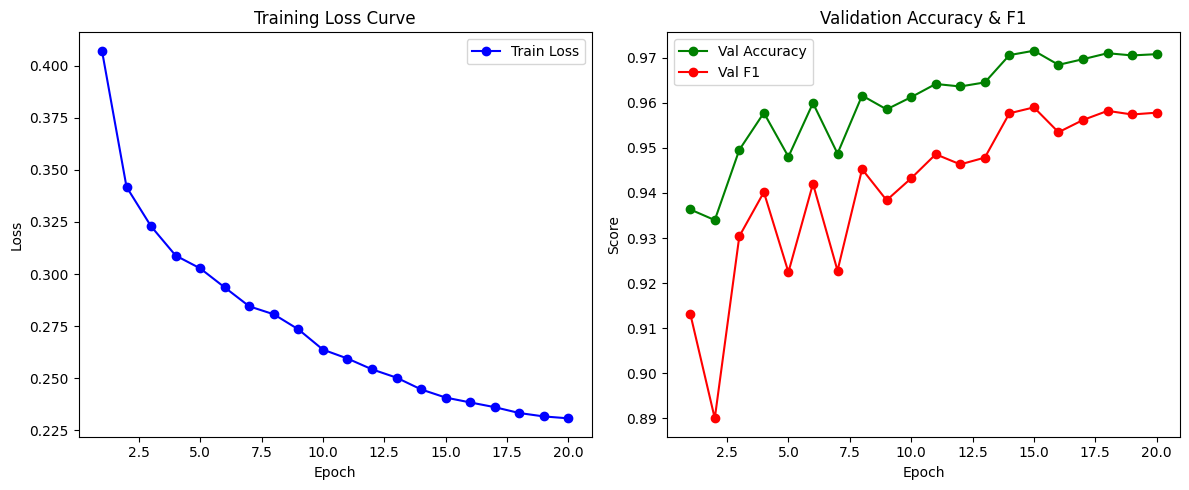


========== Fold 3/5 ==========


/tmp/ipykernel_298904/192118246.py:18: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
  0%|          | 0/1795 [00:00<?, ?it/s]/tmp/ipykernel_298904/2572183642.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Fold 3 | Epoch 01 | loss 0.4059 | val_acc 0.9481 | val_f1 0.9259 | lr 2.98e-04 | 1074.1s
  ↳ Saved best fold checkpoint to: checkpoints/resnet18_fold3_best.pth


  0%|          | 0/1795 [00:00<?, ?it/s]/tmp/ipykernel_298904/2572183642.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Fold 3 | Epoch 02 | loss 0.3391 | val_acc 0.9468 | val_f1 0.9252 | lr 2.93e-04 | 1075.4s


  0%|          | 0/1795 [00:00<?, ?it/s]/tmp/ipykernel_298904/2572183642.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Fold 3 | Epoch 03 | loss 0.3254 | val_acc 0.9479 | val_f1 0.9210 | lr 2.84e-04 | 1085.9s


  0%|          | 0/1795 [00:00<?, ?it/s]/tmp/ipykernel_298904/2572183642.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Fold 3 | Epoch 04 | loss 0.3153 | val_acc 0.9507 | val_f1 0.9322 | lr 2.71e-04 | 1068.5s
  ↳ Saved best fold checkpoint to: checkpoints/resnet18_fold3_best.pth


  0%|          | 0/1795 [00:00<?, ?it/s]/tmp/ipykernel_298904/2572183642.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Fold 3 | Epoch 05 | loss 0.2995 | val_acc 0.9472 | val_f1 0.9276 | lr 2.56e-04 | 1064.5s


  0%|          | 0/1795 [00:00<?, ?it/s]/tmp/ipykernel_298904/2572183642.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Fold 3 | Epoch 06 | loss 0.2937 | val_acc 0.9497 | val_f1 0.9233 | lr 2.38e-04 | 1074.3s


  0%|          | 0/1795 [00:00<?, ?it/s]/tmp/ipykernel_298904/2572183642.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Fold 3 | Epoch 07 | loss 0.2874 | val_acc 0.9574 | val_f1 0.9369 | lr 2.18e-04 | 1086.8s
  ↳ Saved best fold checkpoint to: checkpoints/resnet18_fold3_best.pth


  0%|          | 0/1795 [00:00<?, ?it/s]/tmp/ipykernel_298904/2572183642.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Fold 3 | Epoch 08 | loss 0.2758 | val_acc 0.9620 | val_f1 0.9462 | lr 1.96e-04 | 1067.3s
  ↳ Saved best fold checkpoint to: checkpoints/resnet18_fold3_best.pth


  0%|          | 0/1795 [00:00<?, ?it/s]/tmp/ipykernel_298904/2572183642.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Fold 3 | Epoch 09 | loss 0.2735 | val_acc 0.9618 | val_f1 0.9462 | lr 1.73e-04 | 1053.7s
  ↳ Saved best fold checkpoint to: checkpoints/resnet18_fold3_best.pth


  0%|          | 0/1795 [00:00<?, ?it/s]/tmp/ipykernel_298904/2572183642.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Fold 3 | Epoch 10 | loss 0.2663 | val_acc 0.9616 | val_f1 0.9439 | lr 1.50e-04 | 1052.9s


  0%|          | 0/1795 [00:00<?, ?it/s]/tmp/ipykernel_298904/2572183642.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Fold 3 | Epoch 11 | loss 0.2619 | val_acc 0.9670 | val_f1 0.9529 | lr 1.27e-04 | 1069.5s
  ↳ Saved best fold checkpoint to: checkpoints/resnet18_fold3_best.pth


  0%|          | 0/1795 [00:00<?, ?it/s]/tmp/ipykernel_298904/2572183642.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Fold 3 | Epoch 12 | loss 0.2570 | val_acc 0.9655 | val_f1 0.9501 | lr 1.04e-04 | 1065.7s


  0%|          | 0/1795 [00:00<?, ?it/s]/tmp/ipykernel_298904/2572183642.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Fold 3 | Epoch 13 | loss 0.2515 | val_acc 0.9629 | val_f1 0.9458 | lr 8.19e-05 | 1056.2s


  0%|          | 0/1795 [00:00<?, ?it/s]/tmp/ipykernel_298904/2572183642.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Fold 3 | Epoch 14 | loss 0.2463 | val_acc 0.9669 | val_f1 0.9532 | lr 6.18e-05 | 1071.8s
  ↳ Saved best fold checkpoint to: checkpoints/resnet18_fold3_best.pth


  0%|          | 0/1795 [00:00<?, ?it/s]/tmp/ipykernel_298904/2572183642.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Fold 3 | Epoch 15 | loss 0.2427 | val_acc 0.9687 | val_f1 0.9557 | lr 4.39e-05 | 1063.6s
  ↳ Saved best fold checkpoint to: checkpoints/resnet18_fold3_best.pth


  0%|          | 0/1795 [00:00<?, ?it/s]/tmp/ipykernel_298904/2572183642.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Fold 3 | Epoch 16 | loss 0.2400 | val_acc 0.9681 | val_f1 0.9547 | lr 2.86e-05 | 1061.0s


  0%|          | 0/1795 [00:00<?, ?it/s]/tmp/ipykernel_298904/2572183642.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Fold 3 | Epoch 17 | loss 0.2354 | val_acc 0.9685 | val_f1 0.9551 | lr 1.63e-05 | 1053.7s


  0%|          | 0/1795 [00:00<?, ?it/s]/tmp/ipykernel_298904/2572183642.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Fold 3 | Epoch 18 | loss 0.2352 | val_acc 0.9694 | val_f1 0.9558 | lr 7.34e-06 | 1065.9s
  ↳ Saved best fold checkpoint to: checkpoints/resnet18_fold3_best.pth


  0%|          | 0/1795 [00:00<?, ?it/s]/tmp/ipykernel_298904/2572183642.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Fold 3 | Epoch 19 | loss 0.2328 | val_acc 0.9699 | val_f1 0.9568 | lr 1.85e-06 | 1042.8s
  ↳ Saved best fold checkpoint to: checkpoints/resnet18_fold3_best.pth


  0%|          | 0/1795 [00:00<?, ?it/s]/tmp/ipykernel_298904/2572183642.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Fold 3 | Epoch 20 | loss 0.2304 | val_acc 0.9701 | val_f1 0.9572 | lr 0.00e+00 | 1023.7s
  ↳ Saved best fold checkpoint to: checkpoints/resnet18_fold3_best.pth


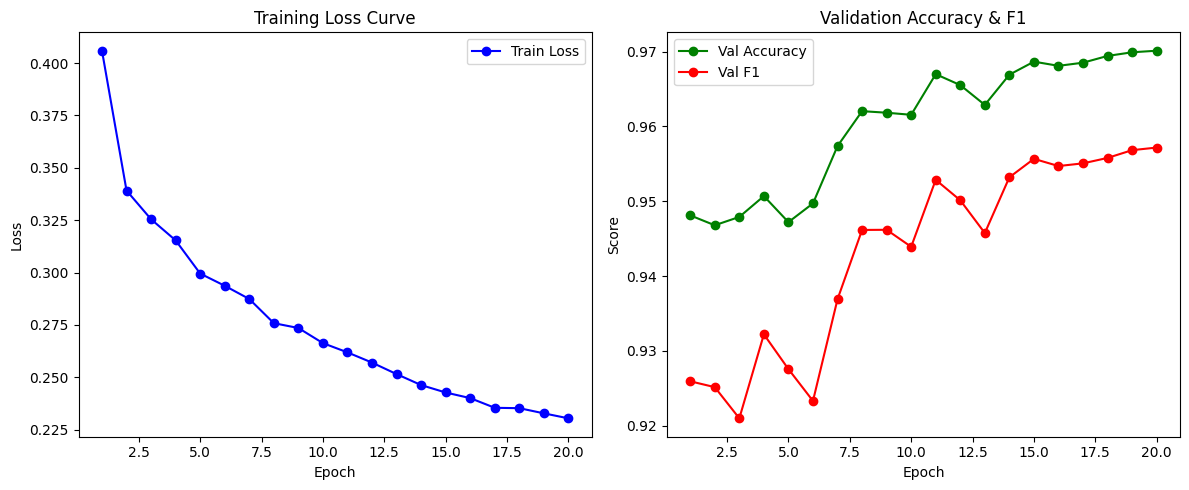


========== Fold 4/5 ==========


/tmp/ipykernel_298904/192118246.py:18: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
  0%|          | 0/1795 [00:00<?, ?it/s]/tmp/ipykernel_298904/2572183642.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Fold 4 | Epoch 01 | loss 0.4105 | val_acc 0.9401 | val_f1 0.9192 | lr 2.98e-04 | 1038.1s
  ↳ Saved best fold checkpoint to: checkpoints/resnet18_fold4_best.pth


  0%|          | 0/1795 [00:00<?, ?it/s]/tmp/ipykernel_298904/2572183642.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Fold 4 | Epoch 02 | loss 0.3420 | val_acc 0.9184 | val_f1 0.8801 | lr 2.93e-04 | 1035.9s


  0%|          | 0/1795 [00:00<?, ?it/s]/tmp/ipykernel_298904/2572183642.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Fold 4 | Epoch 03 | loss 0.3239 | val_acc 0.9475 | val_f1 0.9266 | lr 2.84e-04 | 1036.0s
  ↳ Saved best fold checkpoint to: checkpoints/resnet18_fold4_best.pth


  0%|          | 0/1795 [00:00<?, ?it/s]/tmp/ipykernel_298904/2572183642.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Fold 4 | Epoch 04 | loss 0.3113 | val_acc 0.9591 | val_f1 0.9410 | lr 2.71e-04 | 1037.2s
  ↳ Saved best fold checkpoint to: checkpoints/resnet18_fold4_best.pth


  0%|          | 0/1795 [00:00<?, ?it/s]/tmp/ipykernel_298904/2572183642.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Fold 4 | Epoch 05 | loss 0.2999 | val_acc 0.9592 | val_f1 0.9416 | lr 2.56e-04 | 1035.8s
  ↳ Saved best fold checkpoint to: checkpoints/resnet18_fold4_best.pth


  0%|          | 0/1795 [00:00<?, ?it/s]/tmp/ipykernel_298904/2572183642.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Fold 4 | Epoch 06 | loss 0.2951 | val_acc 0.9563 | val_f1 0.9344 | lr 2.38e-04 | 1037.8s


  0%|          | 0/1795 [00:00<?, ?it/s]/tmp/ipykernel_298904/2572183642.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Fold 4 | Epoch 07 | loss 0.2867 | val_acc 0.9555 | val_f1 0.9379 | lr 2.18e-04 | 1040.0s


  0%|          | 0/1795 [00:00<?, ?it/s]/tmp/ipykernel_298904/2572183642.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Fold 4 | Epoch 08 | loss 0.2771 | val_acc 0.9621 | val_f1 0.9451 | lr 1.96e-04 | 1036.0s
  ↳ Saved best fold checkpoint to: checkpoints/resnet18_fold4_best.pth


  0%|          | 0/1795 [00:00<?, ?it/s]/tmp/ipykernel_298904/2572183642.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Fold 4 | Epoch 09 | loss 0.2732 | val_acc 0.9640 | val_f1 0.9480 | lr 1.73e-04 | 1058.2s
  ↳ Saved best fold checkpoint to: checkpoints/resnet18_fold4_best.pth


  0%|          | 0/1795 [00:00<?, ?it/s]/tmp/ipykernel_298904/2572183642.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Fold 4 | Epoch 10 | loss 0.2667 | val_acc 0.9595 | val_f1 0.9416 | lr 1.50e-04 | 1064.0s


  0%|          | 0/1795 [00:00<?, ?it/s]/tmp/ipykernel_298904/2572183642.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Fold 4 | Epoch 11 | loss 0.2601 | val_acc 0.9639 | val_f1 0.9482 | lr 1.27e-04 | 1067.1s
  ↳ Saved best fold checkpoint to: checkpoints/resnet18_fold4_best.pth


  0%|          | 0/1795 [00:00<?, ?it/s]/tmp/ipykernel_298904/2572183642.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Fold 4 | Epoch 12 | loss 0.2561 | val_acc 0.9702 | val_f1 0.9567 | lr 1.04e-04 | 1033.6s
  ↳ Saved best fold checkpoint to: checkpoints/resnet18_fold4_best.pth


  0%|          | 0/1795 [00:00<?, ?it/s]/tmp/ipykernel_298904/2572183642.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Fold 4 | Epoch 13 | loss 0.2515 | val_acc 0.9664 | val_f1 0.9501 | lr 8.19e-05 | 1056.8s


  0%|          | 0/1795 [00:00<?, ?it/s]/tmp/ipykernel_298904/2572183642.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Fold 4 | Epoch 14 | loss 0.2465 | val_acc 0.9668 | val_f1 0.9532 | lr 6.18e-05 | 1040.1s


  0%|          | 0/1795 [00:00<?, ?it/s]/tmp/ipykernel_298904/2572183642.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Fold 4 | Epoch 15 | loss 0.2419 | val_acc 0.9735 | val_f1 0.9614 | lr 4.39e-05 | 1036.3s
  ↳ Saved best fold checkpoint to: checkpoints/resnet18_fold4_best.pth


  0%|          | 0/1795 [00:00<?, ?it/s]/tmp/ipykernel_298904/2572183642.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Fold 4 | Epoch 16 | loss 0.2392 | val_acc 0.9700 | val_f1 0.9574 | lr 2.86e-05 | 1035.8s


  0%|          | 0/1795 [00:00<?, ?it/s]/tmp/ipykernel_298904/2572183642.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Fold 4 | Epoch 17 | loss 0.2373 | val_acc 0.9726 | val_f1 0.9605 | lr 1.63e-05 | 1035.6s


  0%|          | 0/1795 [00:00<?, ?it/s]/tmp/ipykernel_298904/2572183642.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Fold 4 | Epoch 18 | loss 0.2343 | val_acc 0.9740 | val_f1 0.9625 | lr 7.34e-06 | 1074.4s
  ↳ Saved best fold checkpoint to: checkpoints/resnet18_fold4_best.pth


  0%|          | 0/1795 [00:00<?, ?it/s]/tmp/ipykernel_298904/2572183642.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Fold 4 | Epoch 19 | loss 0.2328 | val_acc 0.9742 | val_f1 0.9627 | lr 1.85e-06 | 1057.6s
  ↳ Saved best fold checkpoint to: checkpoints/resnet18_fold4_best.pth


  0%|          | 0/1795 [00:00<?, ?it/s]/tmp/ipykernel_298904/2572183642.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Fold 4 | Epoch 20 | loss 0.2321 | val_acc 0.9748 | val_f1 0.9634 | lr 0.00e+00 | 1054.4s
  ↳ Saved best fold checkpoint to: checkpoints/resnet18_fold4_best.pth


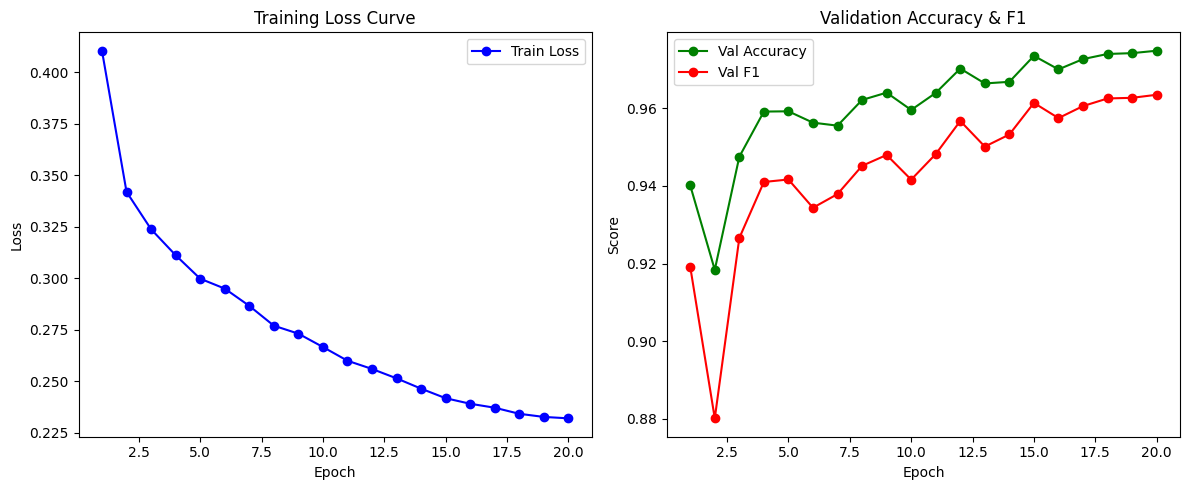


========== Fold 5/5 ==========


/tmp/ipykernel_298904/192118246.py:18: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
  0%|          | 0/1795 [00:00<?, ?it/s]/tmp/ipykernel_298904/2572183642.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Fold 5 | Epoch 01 | loss 0.4079 | val_acc 0.9384 | val_f1 0.9040 | lr 2.98e-04 | 1060.8s
  ↳ Saved best fold checkpoint to: checkpoints/resnet18_fold5_best.pth


  0%|          | 0/1795 [00:00<?, ?it/s]/tmp/ipykernel_298904/2572183642.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Fold 5 | Epoch 02 | loss 0.3404 | val_acc 0.9292 | val_f1 0.9042 | lr 2.93e-04 | 1066.8s
  ↳ Saved best fold checkpoint to: checkpoints/resnet18_fold5_best.pth


  0%|          | 0/1795 [00:00<?, ?it/s]/tmp/ipykernel_298904/2572183642.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Fold 5 | Epoch 03 | loss 0.3262 | val_acc 0.9418 | val_f1 0.9196 | lr 2.84e-04 | 1050.4s
  ↳ Saved best fold checkpoint to: checkpoints/resnet18_fold5_best.pth


  0%|          | 0/1795 [00:00<?, ?it/s]/tmp/ipykernel_298904/2572183642.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Fold 5 | Epoch 04 | loss 0.3085 | val_acc 0.9440 | val_f1 0.9234 | lr 2.71e-04 | 1047.0s
  ↳ Saved best fold checkpoint to: checkpoints/resnet18_fold5_best.pth


  0%|          | 0/1795 [00:00<?, ?it/s]/tmp/ipykernel_298904/2572183642.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Fold 5 | Epoch 05 | loss 0.3020 | val_acc 0.9467 | val_f1 0.9270 | lr 2.56e-04 | 1065.6s
  ↳ Saved best fold checkpoint to: checkpoints/resnet18_fold5_best.pth


  0%|          | 0/1795 [00:00<?, ?it/s]/tmp/ipykernel_298904/2572183642.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Fold 5 | Epoch 06 | loss 0.2910 | val_acc 0.9507 | val_f1 0.9274 | lr 2.38e-04 | 1048.3s
  ↳ Saved best fold checkpoint to: checkpoints/resnet18_fold5_best.pth


  0%|          | 0/1795 [00:00<?, ?it/s]/tmp/ipykernel_298904/2572183642.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Fold 5 | Epoch 07 | loss 0.2869 | val_acc 0.9542 | val_f1 0.9352 | lr 2.18e-04 | 1052.5s
  ↳ Saved best fold checkpoint to: checkpoints/resnet18_fold5_best.pth


  0%|          | 0/1795 [00:00<?, ?it/s]/tmp/ipykernel_298904/2572183642.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Fold 5 | Epoch 08 | loss 0.2789 | val_acc 0.9618 | val_f1 0.9444 | lr 1.96e-04 | 1051.3s
  ↳ Saved best fold checkpoint to: checkpoints/resnet18_fold5_best.pth


  0%|          | 0/1795 [00:00<?, ?it/s]/tmp/ipykernel_298904/2572183642.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Fold 5 | Epoch 09 | loss 0.2731 | val_acc 0.9609 | val_f1 0.9428 | lr 1.73e-04 | 1066.1s


  0%|          | 0/1795 [00:00<?, ?it/s]/tmp/ipykernel_298904/2572183642.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Fold 5 | Epoch 10 | loss 0.2670 | val_acc 0.9635 | val_f1 0.9477 | lr 1.50e-04 | 1050.0s
  ↳ Saved best fold checkpoint to: checkpoints/resnet18_fold5_best.pth


  0%|          | 0/1795 [00:00<?, ?it/s]/tmp/ipykernel_298904/2572183642.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Fold 5 | Epoch 11 | loss 0.2596 | val_acc 0.9632 | val_f1 0.9468 | lr 1.27e-04 | 1049.7s


  0%|          | 0/1795 [00:00<?, ?it/s]/tmp/ipykernel_298904/2572183642.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Fold 5 | Epoch 12 | loss 0.2562 | val_acc 0.9569 | val_f1 0.9375 | lr 1.04e-04 | 1069.6s


  0%|          | 0/1795 [00:00<?, ?it/s]/tmp/ipykernel_298904/2572183642.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Fold 5 | Epoch 13 | loss 0.2490 | val_acc 0.9648 | val_f1 0.9497 | lr 8.19e-05 | 1056.3s
  ↳ Saved best fold checkpoint to: checkpoints/resnet18_fold5_best.pth


  0%|          | 0/1795 [00:00<?, ?it/s]/tmp/ipykernel_298904/2572183642.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Fold 5 | Epoch 14 | loss 0.2471 | val_acc 0.9664 | val_f1 0.9525 | lr 6.18e-05 | 1055.2s
  ↳ Saved best fold checkpoint to: checkpoints/resnet18_fold5_best.pth


  0%|          | 0/1795 [00:00<?, ?it/s]/tmp/ipykernel_298904/2572183642.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Fold 5 | Epoch 15 | loss 0.2402 | val_acc 0.9652 | val_f1 0.9500 | lr 4.39e-05 | 1066.0s


  0%|          | 0/1795 [00:00<?, ?it/s]/tmp/ipykernel_298904/2572183642.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Fold 5 | Epoch 16 | loss 0.2392 | val_acc 0.9667 | val_f1 0.9517 | lr 2.86e-05 | 1051.7s


  0%|          | 0/1795 [00:00<?, ?it/s]/tmp/ipykernel_298904/2572183642.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Fold 5 | Epoch 17 | loss 0.2363 | val_acc 0.9675 | val_f1 0.9533 | lr 1.63e-05 | 1055.1s
  ↳ Saved best fold checkpoint to: checkpoints/resnet18_fold5_best.pth


  0%|          | 0/1795 [00:00<?, ?it/s]/tmp/ipykernel_298904/2572183642.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Fold 5 | Epoch 18 | loss 0.2355 | val_acc 0.9672 | val_f1 0.9528 | lr 7.34e-06 | 1053.3s


  0%|          | 0/1795 [00:00<?, ?it/s]/tmp/ipykernel_298904/2572183642.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Fold 5 | Epoch 19 | loss 0.2333 | val_acc 0.9678 | val_f1 0.9539 | lr 1.85e-06 | 1063.7s
  ↳ Saved best fold checkpoint to: checkpoints/resnet18_fold5_best.pth


  0%|          | 0/1795 [00:00<?, ?it/s]/tmp/ipykernel_298904/2572183642.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Fold 5 | Epoch 20 | loss 0.2321 | val_acc 0.9684 | val_f1 0.9545 | lr 0.00e+00 | 1054.8s
  ↳ Saved best fold checkpoint to: checkpoints/resnet18_fold5_best.pth


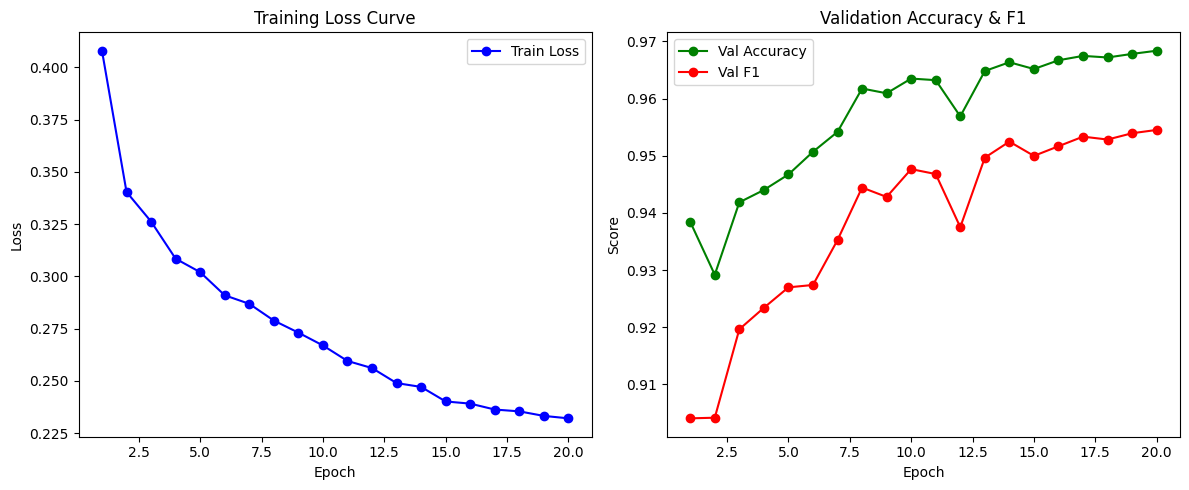


=== CV summary ===
Val F1  per fold: [0.9621, 0.959, 0.9572, 0.9634, 0.9545]
Val Acc per fold: [0.9737, 0.9716, 0.9701, 0.9748, 0.9684]
Mean F1=0.9593 ± 0.0032 | Mean Acc=0.9717 ± 0.0023
Best fold checkpoint: checkpoints/resnet18_fold4_best.pth


In [9]:
# --- Cell 8: K-Fold CV on train+val (test stays held-out) ---
from statistics import mean, pstdev
import pandas as pd

cv_results = []
best_fold_ckpt = None
best_fold_f1 = -1

skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)

for fold, (tr_idx, va_idx) in enumerate(skf.split(trainval_paths, trainval_labels), start=1):
    print(f"\n========== Fold {fold}/{N_FOLDS} ==========")
    train_ds, val_ds, train_loader, val_loader = build_loaders_from_indices(tr_idx, va_idx)

    model = build_model(num_classes=len(class_names), name=MODEL_NAME).to(DEVICE)
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
    scaler = GradScaler()
    criterion = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTH)  # sampler-only strategy

    history = {"train_loss": [], "val_acc": [], "val_f1": []}
    best_state, best_f1, bad = None, -1, 0

    for epoch in range(1, EPOCHS + 1):
        t0 = time.time()
        train_loss = train_one_epoch(model, train_loader, optimizer, scaler, criterion)
        val_acc, val_f1, val_cm, yv, pv = evaluate(val_loader, model)
        scheduler.step()

        history["train_loss"].append(train_loss)
        history["val_acc"].append(val_acc)
        history["val_f1"].append(val_f1)

        print(f"Fold {fold} | Epoch {epoch:02d} | loss {train_loss:.4f} | val_acc {val_acc:.4f} | val_f1 {val_f1:.4f} | lr {scheduler.get_last_lr()[0]:.2e} | {time.time()-t0:.1f}s")

        if val_f1 > best_f1:
            best_f1 = val_f1
            best_state = copy.deepcopy(model.state_dict())
            ck_name = f"{MODEL_NAME}_fold{fold}_best"
            ck_path = save_checkpoint(best_state, class_names, epoch, val_acc, val_f1, ck_name)
            print("  ↳ Saved best fold checkpoint to:", ck_path)
            bad = 0
        else:
            bad += 1
            if bad >= PATIENCE:
                print("  ↳ Early stopping.")
                break

    # Save fold history & curves
    df = pd.DataFrame({"epoch": range(1, len(history["train_loss"])+1),
                       "train_loss": history["train_loss"],
                       "val_acc": history["val_acc"],
                       "val_f1": history["val_f1"]})
    fold_prefix = f"runs/{MODEL_NAME}_fold{fold}"
    df.to_csv(f"{fold_prefix}_history.csv", index=False)
    plot_history(history, save_prefix=fold_prefix)

    # Record fold results
    cv_results.append({"fold": fold, "best_val_f1": best_f1, "best_val_acc": max(history["val_acc"])})
    if best_f1 > best_fold_f1:
        best_fold_f1 = best_f1
        best_fold_ckpt = f"checkpoints/{MODEL_NAME}_fold{fold}_best.pth"

# CV summary
cv_f1s  = [r["best_val_f1"] for r in cv_results]
cv_accs = [r["best_val_acc"] for r in cv_results]
print("\n=== CV summary ===")
print("Val F1  per fold:", [round(x,4) for x in cv_f1s])
print("Val Acc per fold:", [round(x,4) for x in cv_accs])
print(f"Mean F1={mean(cv_f1s):.4f} ± {pstdev(cv_f1s):.4f} | Mean Acc={mean(cv_accs):.4f} ± {pstdev(cv_accs):.4f}")
print("Best fold checkpoint:", best_fold_ckpt)


/tmp/ipykernel_298904/82776748.py:9: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
  0%|          | 0/2244 [00:00<?, ?it/s]/tmp/ipykernel_298904/2572183642.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[FINAL] Epoch 01 | loss 0.3932 | test_acc 0.9486 | test_f1 0.9281 | lr 2.98e-04 | 1322.3s


  0%|          | 0/2244 [00:00<?, ?it/s]/tmp/ipykernel_298904/2572183642.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[FINAL] Epoch 02 | loss 0.3335 | test_acc 0.9493 | test_f1 0.9261 | lr 2.93e-04 | 1305.4s


  0%|          | 0/2244 [00:00<?, ?it/s]/tmp/ipykernel_298904/2572183642.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[FINAL] Epoch 03 | loss 0.3188 | test_acc 0.9474 | test_f1 0.9200 | lr 2.84e-04 | 1297.6s


  0%|          | 0/2244 [00:00<?, ?it/s]/tmp/ipykernel_298904/2572183642.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[FINAL] Epoch 04 | loss 0.3042 | test_acc 0.9504 | test_f1 0.9330 | lr 2.71e-04 | 1297.8s


  0%|          | 0/2244 [00:00<?, ?it/s]/tmp/ipykernel_298904/2572183642.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[FINAL] Epoch 05 | loss 0.2982 | test_acc 0.9402 | test_f1 0.9152 | lr 2.56e-04 | 1307.4s


  0%|          | 0/2244 [00:00<?, ?it/s]/tmp/ipykernel_298904/2572183642.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[FINAL] Epoch 06 | loss 0.2913 | test_acc 0.9617 | test_f1 0.9454 | lr 2.38e-04 | 1295.4s


  0%|          | 0/2244 [00:00<?, ?it/s]/tmp/ipykernel_298904/2572183642.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[FINAL] Epoch 07 | loss 0.2811 | test_acc 0.9608 | test_f1 0.9413 | lr 2.18e-04 | 1305.9s


  0%|          | 0/2244 [00:00<?, ?it/s]/tmp/ipykernel_298904/2572183642.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[FINAL] Epoch 08 | loss 0.2758 | test_acc 0.9651 | test_f1 0.9503 | lr 1.96e-04 | 1305.9s


  0%|          | 0/2244 [00:00<?, ?it/s]/tmp/ipykernel_298904/2572183642.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[FINAL] Epoch 09 | loss 0.2716 | test_acc 0.9570 | test_f1 0.9361 | lr 1.73e-04 | 1304.4s


  0%|          | 0/2244 [00:00<?, ?it/s]/tmp/ipykernel_298904/2572183642.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[FINAL] Epoch 10 | loss 0.2646 | test_acc 0.9578 | test_f1 0.9382 | lr 1.50e-04 | 1305.1s


  0%|          | 0/2244 [00:00<?, ?it/s]/tmp/ipykernel_298904/2572183642.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[FINAL] Epoch 11 | loss 0.2594 | test_acc 0.9608 | test_f1 0.9431 | lr 1.27e-04 | 1304.7s


  0%|          | 0/2244 [00:00<?, ?it/s]/tmp/ipykernel_298904/2572183642.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[FINAL] Epoch 12 | loss 0.2557 | test_acc 0.9680 | test_f1 0.9532 | lr 1.04e-04 | 1304.4s


  0%|          | 0/2244 [00:00<?, ?it/s]/tmp/ipykernel_298904/2572183642.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[FINAL] Epoch 13 | loss 0.2489 | test_acc 0.9706 | test_f1 0.9580 | lr 8.19e-05 | 15444.9s


  0%|          | 0/2244 [00:00<?, ?it/s]/tmp/ipykernel_298904/2572183642.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[FINAL] Epoch 14 | loss 0.2443 | test_acc 0.9702 | test_f1 0.9578 | lr 6.18e-05 | 1309.6s


  0%|          | 0/2244 [00:00<?, ?it/s]/tmp/ipykernel_298904/2572183642.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[FINAL] Epoch 15 | loss 0.2414 | test_acc 0.9690 | test_f1 0.9557 | lr 4.39e-05 | 1309.8s


  0%|          | 0/2244 [00:00<?, ?it/s]/tmp/ipykernel_298904/2572183642.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[FINAL] Epoch 16 | loss 0.2384 | test_acc 0.9709 | test_f1 0.9587 | lr 2.86e-05 | 1308.3s


  0%|          | 0/2244 [00:00<?, ?it/s]/tmp/ipykernel_298904/2572183642.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[FINAL] Epoch 17 | loss 0.2334 | test_acc 0.9720 | test_f1 0.9595 | lr 1.63e-05 | 1309.6s


  0%|          | 0/2244 [00:00<?, ?it/s]/tmp/ipykernel_298904/2572183642.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[FINAL] Epoch 18 | loss 0.2326 | test_acc 0.9717 | test_f1 0.9593 | lr 7.34e-06 | 1308.8s


  0%|          | 0/2244 [00:00<?, ?it/s]/tmp/ipykernel_298904/2572183642.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[FINAL] Epoch 19 | loss 0.2328 | test_acc 0.9731 | test_f1 0.9614 | lr 1.85e-06 | 1306.7s


  0%|          | 0/2244 [00:00<?, ?it/s]/tmp/ipykernel_298904/2572183642.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[FINAL] Epoch 20 | loss 0.2315 | test_acc 0.9733 | test_f1 0.9616 | lr 0.00e+00 | 1313.9s


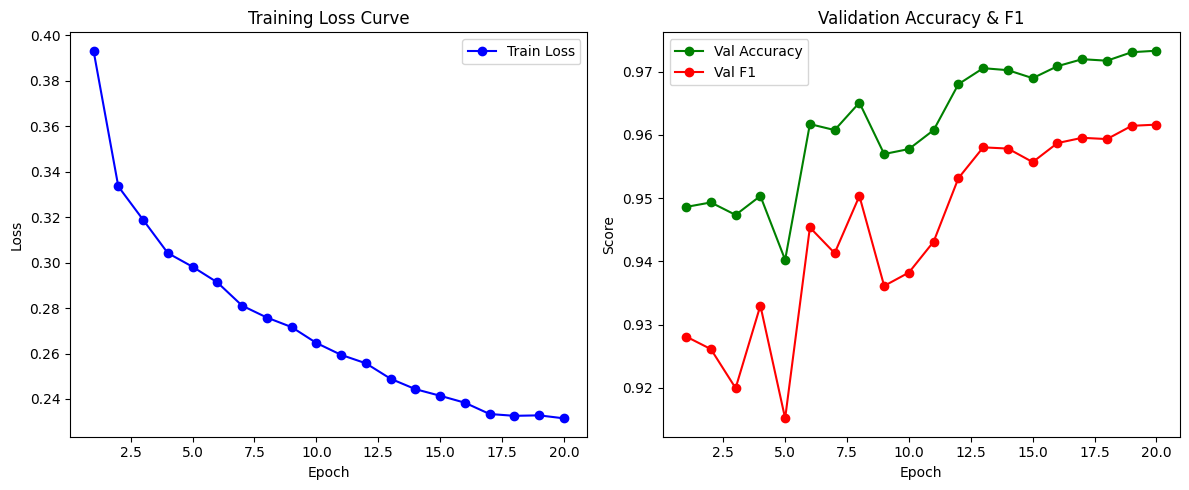

Final checkpoint saved: checkpoints/resnet18_final.pth


In [ ]:
# --- Cell 9: Train on FULL train+val, then evaluate on TEST once ---
# Use all train+val images for final model
all_idx = np.arange(len(trainval_samples))
train_ds_full, val_ds_dummy, train_loader_full, _ = build_loaders_from_indices(all_idx, [])  # empty val

model = build_model(num_classes=len(class_names), name=MODEL_NAME).to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
scaler = GradScaler()
criterion = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTH)

history_final = {"train_loss": [], "val_acc": [], "val_f1": []}

for epoch in range(1, EPOCHS + 1):
    t0 = time.time()
    train_loss = train_one_epoch(model, train_loader_full, optimizer, scaler, criterion)
    # evaluate on held-out test every epoch (optional)
    val_acc, val_f1, _, _, _ = evaluate(test_loader, model)
    scheduler.step()
    history_final["train_loss"].append(train_loss)
    history_final["val_acc"].append(val_acc)
    history_final["val_f1"].append(val_f1)
    print(f"[FINAL] Epoch {epoch:02d} | loss {train_loss:.4f} | test_acc {val_acc:.4f} | test_f1 {val_f1:.4f} | lr {scheduler.get_last_lr()[0]:.2e} | {time.time()-t0:.1f}s")

# Save curves & model
plot_history(history_final, save_prefix=f"runs/{MODEL_NAME}_final")
final_ck = save_checkpoint(model.state_dict(), class_names, epoch=EPOCHS,
                           val_acc=history_final['val_acc'][-1],
                           val_f1=history_final['val_f1'][-1],
                           prefix=f"{MODEL_NAME}_final")

print("Final checkpoint saved:", final_ck)



=== TEST RESULTS ===
Accuracy : 0.9733
Macro F1 : 0.9616

Classification Report:
              precision    recall  f1-score   support

         CNV     0.9745    0.9861    0.9803      5617
         DME     0.9703    0.9770    0.9736      1739
      DRUSEN     0.9210    0.8947    0.9076      1329
      NORMAL     0.9901    0.9799    0.9850      3984

    accuracy                         0.9733     12669
   macro avg     0.9640    0.9594    0.9616     12669
weighted avg     0.9732    0.9733    0.9732     12669



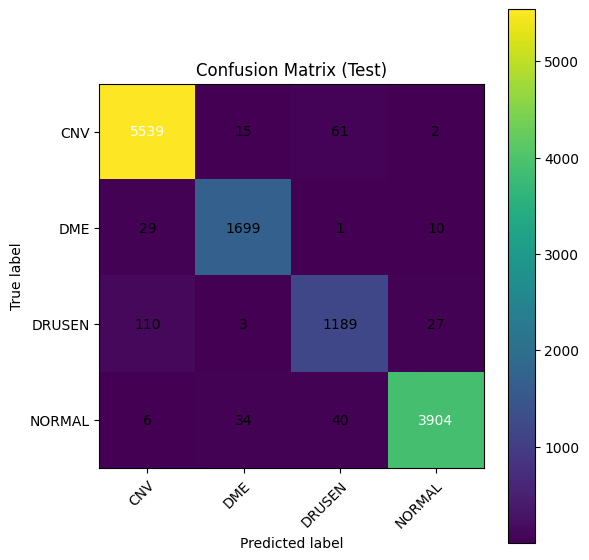

In [ ]:
# --- Cell 10: Test evaluation & reports ---
test_acc, test_f1, test_cm, y_true, y_pred = evaluate(test_loader, model)

print("\n=== TEST RESULTS ===")
print("Accuracy :", round(test_acc, 4))
print("Macro F1 :", round(test_f1, 4))

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

# Confusion Matrix Plot (and save)
fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(test_cm, interpolation='nearest')
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(len(class_names)), yticks=np.arange(len(class_names)),
       xticklabels=class_names, yticklabels=class_names,
       ylabel='True label', xlabel='Predicted label', title='Confusion Matrix (Test)')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

thresh = test_cm.max() / 2.
for i in range(test_cm.shape[0]):
    for j in range(test_cm.shape[1]):
        ax.text(j, i, format(test_cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if test_cm[i, j] > thresh else "black")
plt.tight_layout()
plt.savefig("runs/confusion_matrix_test.png", dpi=200, bbox_inches="tight")
plt.show()


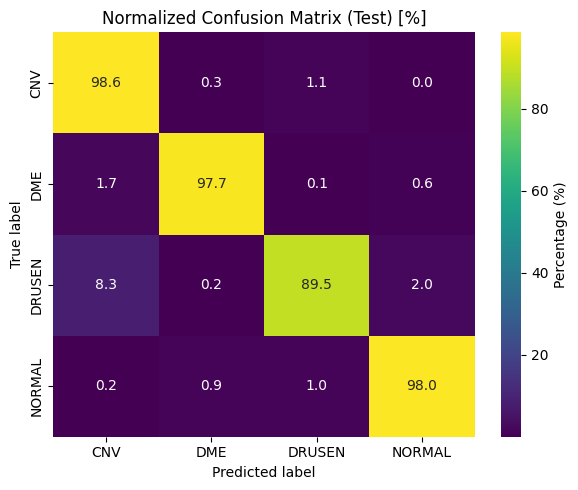

[SAVED] C:\Users\sheno\OneDrive\CODCSD201F-006-SetupFile\Desktop\FINAL\models\svm_confusion_matrix_normalized.png


In [9]:
# --- Cell 10: Test evaluation & reports (Improved) ---
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Example confusion matrix (replace with your cm variable)
cm = np.array([
    [5539,  15,  61,   2],
    [  29, 1699,  1,  10],
    [ 110,   3, 1189, 27],
    [   6,  34,   40, 3904]
])

CLASSES = ["CNV", "DME", "DRUSEN", "NORMAL"]

# --- Convert to percentage (row-wise normalization) ---
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] * 100

# Plot normalized confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm_norm, annot=True, fmt=".1f", cmap="viridis",
            xticklabels=CLASSES, yticklabels=CLASSES, cbar_kws={'label': 'Percentage (%)'})
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Normalized Confusion Matrix (Test) [%]")
plt.tight_layout()
plt.show()



plt.figure(figsize=(6,5))
sns.heatmap(cm_norm, annot=True, fmt=".1f", cmap="viridis",
            xticklabels=CLASSES, yticklabels=CLASSES, cbar_kws={'label': 'Percentage (%)'})
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Normalized Confusion Matrix (Test) [%]")
plt.tight_layout()
plt.savefig(out_path, dpi=300)
plt.close()
print(f"[SAVED] {out_path}")



/home/sheno/tf/lib/python3.12/site-packages/torch/nn/modules/module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


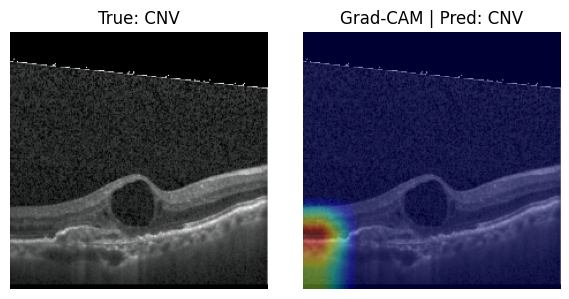

Saved: runs/gradcam/gradcam_CNV_1.png


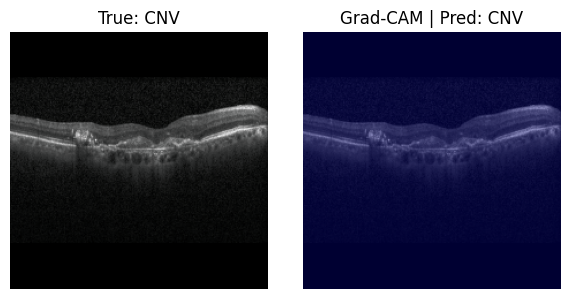

Saved: runs/gradcam/gradcam_CNV_2.png


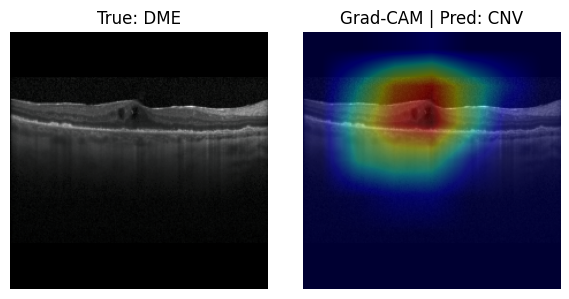

Saved: runs/gradcam/gradcam_DME_1.png


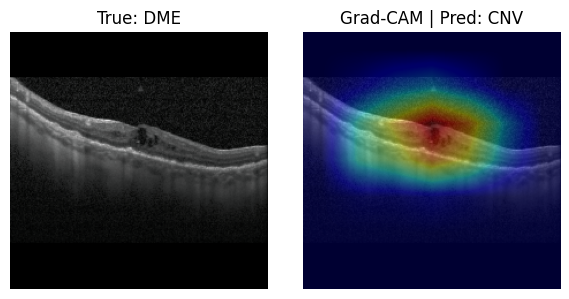

Saved: runs/gradcam/gradcam_DME_2.png


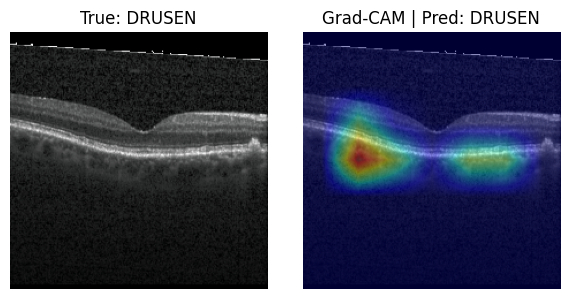

Saved: runs/gradcam/gradcam_DRUSEN_1.png


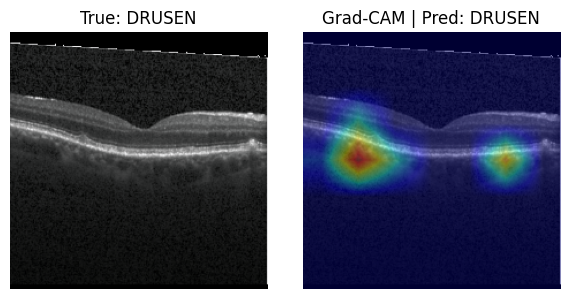

Saved: runs/gradcam/gradcam_DRUSEN_2.png


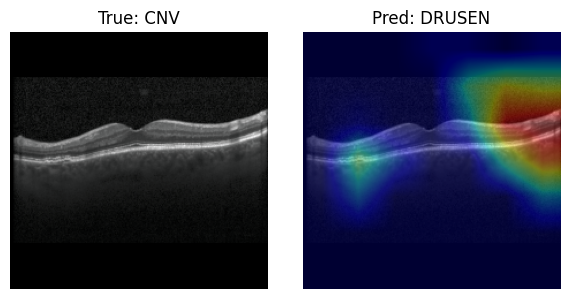

Saved: runs/gradcam_mis/mis_1_CNV_as_DRUSEN.png


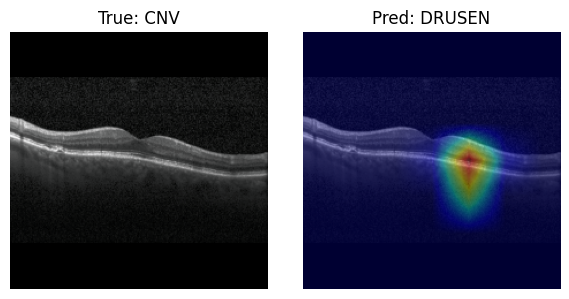

Saved: runs/gradcam_mis/mis_2_CNV_as_DRUSEN.png


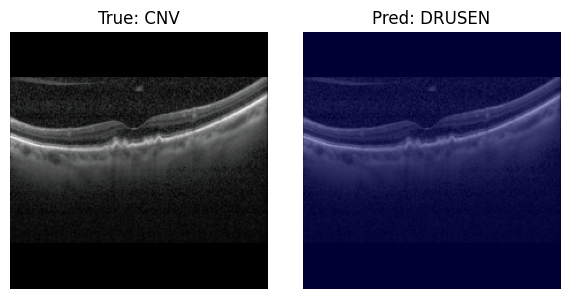

Saved: runs/gradcam_mis/mis_3_CNV_as_DRUSEN.png


In [12]:
# --- Cell 11: Grad-CAM for report & deployment previews ---
import torch.nn.functional as F

def get_target_layer(m, name):
    if name.startswith("resnet"):
        block = m.layer4[-1]
        return block.conv3 if hasattr(block, "conv3") else block.conv2
    elif name == "convnext_tiny":
        return m.features[-1][-1].dwconv
    else:
        raise ValueError(f"Grad-CAM layer not defined for {name}")

target_layer = get_target_layer(model, MODEL_NAME)
_activ, _grads = {}, {}

def _fwd_hook(_, __, output): _activ["value"] = output.detach()
def _bwd_hook(_, grad_in, grad_out): _grads["value"] = grad_out[0].detach()
h_fwd = target_layer.register_forward_hook(_fwd_hook)
h_bwd = target_layer.register_backward_hook(_bwd_hook)

IMAGENET_MEAN = np.array([0.485, 0.456, 0.406])
IMAGENET_STD  = np.array([0.229, 0.224, 0.225])

def denorm_to_uint8(t):
    x = t.permute(1,2,0).cpu().numpy()
    x = (x * IMAGENET_STD + IMAGENET_MEAN); x = np.clip(x, 0, 1)
    return (x*255).astype(np.uint8)

def gradcam_map(x1, class_idx=None):
    model.eval(); _activ.clear(); _grads.clear()
    out = model(x1)
    if class_idx is None: class_idx = out.argmax(1).item()
    score = out[0, class_idx]
    model.zero_grad(set_to_none=True)
    score.backward(retain_graph=True)
    A = _activ["value"]; dA = _grads["value"]
    weights = dA.mean(dim=(2,3), keepdim=True)
    cam = (weights * A).sum(dim=1)
    cam = F.relu(cam)[0]
    cam = cam - cam.min()
    if cam.max() > 0: cam = cam / cam.max()
    cam = F.interpolate(cam.unsqueeze(0).unsqueeze(0), size=x1.shape[-2:], mode="bilinear", align_corners=False)
    return cam[0,0].cpu().numpy()

def overlay_heatmap(img_uint8, cam, alpha=0.4):
    from matplotlib import cm
    heat = (cm.jet(cam)[..., :3] * 255).astype(np.uint8)
    return (alpha*heat + (1-alpha)*img_uint8).astype(np.uint8)

def save_gradcam_examples(ds, classes=("CNV","DME","DRUSEN"), k=2, out_dir="runs/gradcam"):
    os.makedirs(out_dir, exist_ok=True)
    for cname in classes:
        cidx = class_names.index(cname)
        idxs = [i for i, (_, y) in enumerate(ds.samples) if y == cidx][:k]
        for j, i in enumerate(idxs, start=1):
            path, y = ds.samples[i]
            img_t, _ = ds[i]
            x = img_t.unsqueeze(0).to(DEVICE)
            cam = gradcam_map(x)
            img_vis = denorm_to_uint8(img_t)
            overlay = overlay_heatmap(img_vis, cam)
            plt.figure(figsize=(6,3))
            plt.subplot(1,2,1); plt.imshow(img_vis); plt.axis("off"); plt.title(f"True: {class_names[y]}")
            pred = model(x).argmax(1).item()
            plt.subplot(1,2,2); plt.imshow(overlay); plt.axis("off"); plt.title(f"Grad-CAM | Pred: {class_names[pred]}")
            fname = os.path.join(out_dir, f"gradcam_{cname}_{j}.png")
            plt.tight_layout(); plt.savefig(fname, dpi=200, bbox_inches="tight"); plt.show()
            print("Saved:", fname)

save_gradcam_examples(test_ds, classes=("CNV","DME","DRUSEN"), k=2, out_dir="runs/gradcam")

# Optional: visualize a few misclassifications, if any
def save_misclass_gradcam(ds, y_true, y_pred, max_n=3, out_dir="runs/gradcam_mis"):
    os.makedirs(out_dir, exist_ok=True)
    where = np.where(y_true != y_pred)[0][:max_n]
    if len(where) == 0: 
        print("No misclassifications found to visualize.")
        return
    for rank, i in enumerate(where, start=1):
        path, true_label = ds.samples[i]
        img_t, _ = ds[i]; x = img_t.unsqueeze(0).to(DEVICE)
        cam = gradcam_map(x)
        img_vis = denorm_to_uint8(img_t)
        overlay = overlay_heatmap(img_vis, cam)
        pred = model(x).argmax(1).item()
        plt.figure(figsize=(6,3))
        plt.subplot(1,2,1); plt.imshow(img_vis); plt.axis("off"); plt.title(f"True: {class_names[true_label]}")
        plt.subplot(1,2,2); plt.imshow(overlay); plt.axis("off"); plt.title(f"Pred: {class_names[pred]}")
        fname = os.path.join(out_dir, f"mis_{rank}_{class_names[true_label]}_as_{class_names[pred]}.png")
        plt.tight_layout(); plt.savefig(fname, dpi=200, bbox_inches="tight"); plt.show()
        print("Saved:", fname)

# Use y_true/y_pred from Cell 10 if available
try:
    save_misclass_gradcam(test_ds, y_true, y_pred, max_n=3)
except Exception as e:
    print("Skip misclass Grad-CAM (run Cell 10 first).", e)

# cleanup hooks
h_fwd.remove(); h_bwd.remove()


In [13]:
# --- Cell 12: Save final weights as .pth AND .pkl to your Windows folder ---
import pickle

state = model.state_dict()
pth_path = os.path.join(MODELS_DIR, f"{MODEL_NAME}_oct2017_final_weights.pth")
pkl_path = os.path.join(MODELS_DIR, f"{MODEL_NAME}_oct2017_final_weights.pkl")

torch.save(state, pth_path)
with open(pkl_path, "wb") as f: pickle.dump(state, f)

print("Saved:", pth_path)
print("Saved:", pkl_path)


Saved: /mnt/c/Users/sheno/OneDrive/CODCSD201F-006-SetupFile/Desktop/FINAL/models/resnet18_oct2017_final_weights.pth
Saved: /mnt/c/Users/sheno/OneDrive/CODCSD201F-006-SetupFile/Desktop/FINAL/models/resnet18_oct2017_final_weights.pkl
